# Preamble

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
import os
from xmitgcm import open_mdsdataset
from xmitgcm.utils import get_grid_from_input, get_extra_metadata

from myutils import *
from MITgcmutils import llc
import xarray as xr
import cmocean.cm as cmo
#import cartopy.crs as ccrs
import cartopy as cart

def cnorm(vm):
    return colors.Normalize( vmin=-vm,vmax=vm )

def sq(a):
    import numpy as np
    a = np.squeeze(a)
    masked_array=np.ma.masked_where(a==0., a)
    return masked_array

def mosaic_llc(field):
    return np.vstack([np.hstack([np.vstack([np.rot90(field[i]) for i in [9,8,7]]),
                                 np.vstack([np.rot90(field[i]) for i in [12,11,10]]),
                                 np.vstack([field[i] for i in [0,1,2]]),
                                 np.vstack([field[i] for i in [3,4,5]])]),
                      np.hstack([np.rot90(field[6])*np.tri(90)[::-1,:],np.triu(np.rot90(field[6],k=2))*np.tri(90)[::-1,:],
                                 np.triu(np.rot90(field[6],k=-1)),np.zeros(field[6].shape)])])[30:315,:]

def llc13to5faces(field):
    """
    fld = llc13to5faces(field) returns a list of 5 faces constructed from 
    the input of a 13-faces field as returned from 
    xmitgcm.open_mdsdataset(...,geometry='llc')
    """
    return [np.vstack((field[0,...],field[1,...],field[2,...])),
            np.vstack((field[3,...],field[4,...],field[5,...])),
            field[6,...],
            np.hstack((field[7,...],field[8,...],field[9,...])),
            np.hstack((field[10,...],field[11,...],field[12,...]))]

def symNorm(vmax):
    import matplotlib.colors as mcolors
    return mcolors.Normalize(vmin=-vmax,vmax=vmax)

## paths etc

In [2]:
deltat=1800.
ny, nx = 1170, 90

bdir='/albedo/work/projects/p_idemix_tr181/llc90'
gdir='/albedo/work/projects/p_idemix_tr181/llc90/grid'
rdir=os.path.join(bdir,'run22')
fdir='/albedo/home/mlosch/MITgcm/MITgcm/idemix_test/llc90/testfigs'

In [3]:
llc90_extra_metadata = get_extra_metadata(domain='llc', nx=90)
grid = get_grid_from_input(os.path.join('/albedo/home/mlosch/MITgcm/nils/llc90/input','tile<NFACET>.mitgrid'),
                           geometry='llc', extra_metadata=llc90_extra_metadata)

In [4]:
#del ds
#ds = open_mdsdataset(os.path.join(rdir),prefix=['diagsKPP', 'diags3D', 'diags2D'],
ds = open_mdsdataset(os.path.join(rdir),prefix=['diagsGGL90', 'diagsKrN2', 'diags3D', 'diags2D'],
                     delta_t=deltat,ref_date="1958-1-1 0:0:0",geometry='llc') #,ignore_unknown_vars=True)
coords = ds.coords.to_dataset().reset_coords()
#ds = ds.reset_coords(drop=True)
# We generate the extra metadata needed for multi-faceted grids

## LLCMapper

In [5]:
import pyresample

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, lon_0=-60, tstr=None, **plt_kwargs):

        assert set(da.dims) == set(['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)

        x,y = self.new_grid_lon, self.new_grid_lat

        p = ax.pcolormesh(x, y, field, transform=cart.crs.PlateCarree(), **plt_kwargs)
        # p = ax.contourf(x, y, field, transform=cart.crs.PlateCarree(), **plt_kwargs)

        # ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
        # ax.add_feature(cart.feature.LAND, facecolor=landcolor, zorder=3)
        ax.add_feature(cart.feature.COASTLINE, zorder=4, edgecolor='k')
        gl = ax.gridlines(zorder=4)

        if tstr is not None:
            ax.set_title('%s'%(tstr))
            
        label = None
        # if da.name is not None:
        #     label = da.name
        # if 'units' in da.attrs:
        #     label += ' (%s)' % da.attrs['units']
        # cbarextend='both'
        # try:
        #     mynorm = plt_kwargs.pop('norm')
        #     if mynorm.vmin == 0.: cbarextend='max'
        # except:
        #     cbarextend='both'

        # shrinkfac=1.
        # cb = plt.colorbar(p, ax=ax, shrink=shrinkfac, label=label, extend=cbarextend, orientation='horizontal')

        return ax, p, gl
    
class LLCinterp:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(
            lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, 90, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(
            lons=self.new_grid_lon, lats=self.new_grid_lat)

    def __call__(self, da):

        assert set(da.dims) == set(
            ['face', 'j', 'i']), "da must have dimensions ['face', 'j', 'i']"

        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.values,
                                                    self.new_grid,
                                                    radius_of_influence=100e3,
                                                    fill_value=None)
        return field

In [6]:
ds.isel(time=-1)
len(ds.k)
print(len(ds.k),len(ds.time))

50 218


In [13]:
import seawater as sw
m2db = -9.81*1035*1e-4

def mixing_weights(ds):
    # mixing weights
    dz = (ds.hFacC*ds.drF).values
    hl, hu = dz[1:,...], dz[:-1,...]
    hs = hu+hl
    hs = np.where(hs>0,hs,np.Inf)
    return hu/hs, hl/hs

def cabbeling(ds):
    hu, hl = mixing_weights(ds)
    s = ds.SALT.values
    p = np.tile(ds.Z.values.reshape((len(ds.k),1,1))*m2db,(1,s.shape[-2],s.shape[-1]))
    t = sw.temp(s, ds.THETA.values, p, pr=0)
    n2,qu,pu = sw.bfrq(s,t,p)
    rhoUp = sw.pden(s[:-1,...],t[:-1,...],p[:-1,...],pu)
    rhoDn = sw.pden(s[1:,...], t[1:,...], p[1:,...], pu)
    rhom = rhoUp*hu + rhoDn*hl
    # rhoInSitu = sw.dens(s,t,p)
    # rhom = (rhoInSitu[:-1,...]*hu+rhoInSitu[1:,...]*hl)
    msk = np.where(ds.hFacC>0,1,0)
    tn = t[:-1,...]*hu + t[1:,...]*hl
    sn = s[:-1,...]*hu + s[1:,...]*hl
    rho = sw.dens(sn,tn,pu)
    return (rho-rhom)*msk[:-1,...]*msk[1:,...]

cab=np.zeros((49,13,90,90))
for i in range(13):
    print('face %i'%i)
    cab[:,i,:,:] = cabbeling(ds.isel(time=-1,face=i))

face 0
face 1
face 2
face 3
face 4
face 5
face 6
face 7
face 8
face 9
face 10
face 11
face 12


In [8]:
i=0
for k in range(49): print(k,cab[k,i,:,:].min(),(cab[k,i,:,:]<0).sum())

0 -0.000244140625 704
1 -0.000244140625 551
2 -0.000244140625 499
3 -0.0003662109375 294
4 -0.000244140625 184
5 -0.000244140625 189
6 -0.000244140625 200
7 -0.000244140625 154
8 -0.000244140625 568
9 -0.000244140625 210
10 -0.0003662109375 1289
11 -0.000244140625 420
12 -0.0003662109375 627
13 -0.0003662109375 639
14 -0.000244140625 387
15 -0.0003662109375 918
16 -0.000244140625 607
17 -0.0003662109375 646
18 -0.0003662109375 895
19 -0.0003662109375 462
20 -0.000244140625 466
21 -0.0003662109375 478
22 -0.000244140625 511
23 -0.000244140625 526
24 -0.0003662109375 1095
25 -0.0003662109375 786
26 -0.000244140625 263
27 -0.0003662109375 1013
28 -0.0003662109375 727
29 -0.000244140625 490
30 -0.0003662109375 1387
31 -0.0003662109375 729
32 -0.0003662109375 767
33 -0.0003662109375 896
34 -0.0003662109375 1326
35 -0.000244140625 922
36 -0.000244140625 707
37 -0.0003662109375 1129
38 -0.00048828125 2028
39 -0.0003662109375 1413
40 -0.0003662109375 1414
41 -0.0003662109375 1602
42 -0.0003662

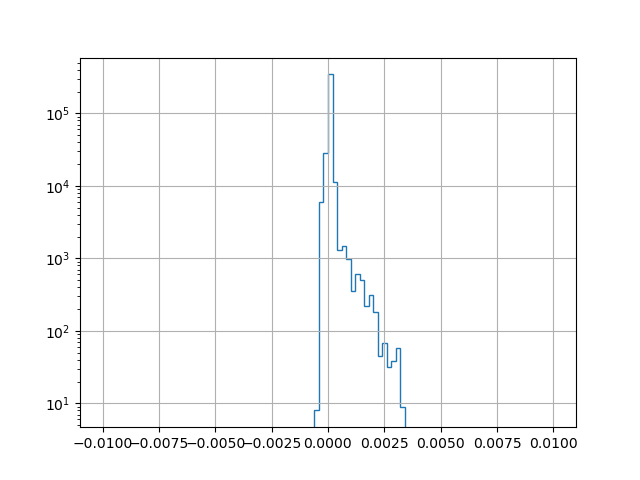

In [14]:
plt.close('all')
plt.figure();
counts, bins = np.histogram(sq(cab[:,i,:,:].ravel()),bins=np.linspace(-1e-2,1e-2,101))
plt.stairs(counts, bins)
plt.gca().set_yscale('log')
plt.grid()

In [15]:
#plt.hist?

Text(0.5, 1.0, 'rho-rhom')

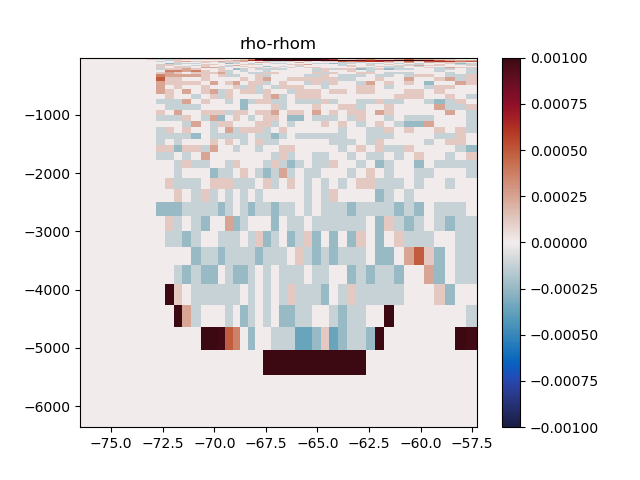

In [16]:
i=0
msk=np.where(ds.hFacC>0,1,0)
cab = cab*msk[:-1,...]*msk[1:,...]
vmx=0.001
pckwargs = dict(norm=colors.Normalize(vmin=-vmx,vmax=vmx), cmap=cmo.balance)
plt.figure()
#plt.pcolormesh(coords.XG[0,60,:],coords.Zu[1:],sq(cab[:,60,:]),**pckwargs)
#plt.pcolormesh(grid.XG[0,:,:],grid.YG[0,:,:],sq(cab[34,0,:,:])) #,**pckwargs)
#plt.pcolormesh(sq(cab[34,0,45:,:]),**pckwargs)
plt.pcolormesh(grid.YG[i,45:,18],ds.Zu[1:],np.squeeze(cab[:,i,45:,18]),**pckwargs)
#plt.pcolormesh(grid.XG[0,:,:],grid.YG[0,:,:],sq(ds.Depth[0,:,:]))
plt.colorbar()
plt.title('rho-rhom')
#plt.xlim([-50,60])

In [12]:
mapper = LLCMapper(coords)
mapper(sq(cab[34,:,:,:]), tstr=("cabbeling"),
       levels=50, extend='both', cmap=cmo.balance)

AttributeError: 'MaskedArray' object has no attribute 'dims'